<a href="https://colab.research.google.com/github/0su1327/Graduation_Thesis/blob/Model/train_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Training One-class Autoencoder for NSL-KDD Classificiation
# Import required packages
import os
import itertools

import numpy as np
import pandas as pd
import h5py

from keras.layers import Input, Dense, LeakyReLU, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from keras.models import Model
from keras import regularizers
from keras.layers import GaussianNoise

In [ ]:
def get_dataset(dirname=os.path.join('..', 'hdf5'), filename=None, tagname=None):
    if filename is None or tagname is None:
        raise ValueError('File name and tag name should be set.')
    with h5py.File(os.path.join(dirname, filename), 'r') as hdf:
        return hdf[tagname][:]

In [ ]:
def get_stacked_autoencoder(loss_func):
    # input layer
    inp = Input(shape=(109,)) # layer 1 -> main.py의 to_machine_readable 함수에서 추출된 feature 수가 114개

    # encoding layers
    enc = Dense(512)(inp) # layer 2
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)   # relu는 max(0, z), leakyRelu는 max(0.01z, z)이므로 z가 음수이면 기울기 0.01 갖게 된다. Relu 보다 학습이 더 잘된다.
    enc = Dense(256)(enc) # layer 3
    # enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(128)(enc) # layer 4
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)

    # bottleneck layer
    mid = Dense(64)(enc) # layer 5
    # mid = Dropout(0.5)(mid)
    mid = LeakyReLU(0.01)(mid)

    # decoding layers
    dec = Dense(128)(mid) # layer 6
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(256)(dec) # layer 7
    # dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(512)(dec) # layer 8
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)

    # output layer
    out = Dense(109, activation='sigmoid')(dec) # 2진분류(normal/abnormal)를 위해 시그모이드 함수 사용
    # 출력층의 뉴런이 여러 개이면, 각 뉴런은 입력층의 각 특성(feature)에 대한 복원값을 출력하게 됩니다.
    # 이렇게 출력층에 여러 개의 뉴런이 있는 오토인코더를 다중 출력 오토인코더(Multi-Output Autoencoder)라 한다.


    # create new model
    autoencoder = Model(inp, out)
    autoencoder.compile(optimizer='rmsprop', loss=loss_func)
    return autoencoder

def get_denoising_autoencoder(loss_func):
    # input layer
    inp = Input(shape=(109,)) # layer 1

    # add noise to the input
    noisy_input = GaussianNoise(0.1)(inp)

    # encoding layers
    enc = Dense(512)(noisy_input) # layer 2
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(256)(enc) # layer 3
    # enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(128)(enc) # layer 4
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)

    # bottleneck layer
    mid = Dense(64)(enc) # layer 5
    # mid = Dropout(0.5)(mid)
    mid = LeakyReLU(0.01)(mid)

    # decoding layers
    dec = Dense(128)(mid) # layer 6
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(256)(dec) # layer 7
    # dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(512)(dec) # layer 8
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)

    # output layer
    out = Dense(109, activation='sigmoid')(dec)

    # create new model
    autoencoder = Model(inp, out)
    autoencoder.compile(optimizer='rmsprop', loss=loss_func)
    return autoencoder

def get_sparse_autoencoder(loss_func):
    # input layer
    inp = Input(shape=(109,)) # layer 1 -> main.py의 to_machine_readable 함수에서 추출된 feature 수가 114개

    # encoding layers
    enc = Dense(64)(inp) # layer 2
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)   # relu는 max(0, z), leakyRelu는 max(0.01z, z)이므로 z가 음수이면 기울기 0.01 갖게 된다. Relu 보다 학습이 더 잘된다.
    enc = Dense(128)(enc) # layer 3
    # enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(256)(enc) # layer 4
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)

    # bottleneck layer
    mid = Dense(512, activity_regularizer=regularizers.l1(1e-3),
                kernel_regularizer=regularizers.l2(1e-3))(enc)
    # mid = Dropout(0.5)(mid)
    mid = LeakyReLU(0.01)(mid)

    # decoding layers
    dec = Dense(256)(mid) # layer 6
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(128)(dec) # layer 7
    # dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(64)(dec) # layer 8
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)

    # output layer
    out = Dense(109, activation='sigmoid')(dec) # 2진분류(normal/abnormal)를 위해 시그모이드 함수 사용
    # 출력층의 뉴런이 여러 개이면, 각 뉴런은 입력층의 각 특성(feature)에 대한 복원값을 출력하게 됩니다.
    # 이렇게 출력층에 여러 개의 뉴런이 있는 오토인코더를 다중 출력 오토인코더(Multi-Output Autoencoder)라 한다.


    # create new model
    autoencoder = Model(inp, out)
    autoencoder.compile(optimizer='rmsprop', loss=loss_func)
    return autoencoder

In [ ]:
# Model summary
model = get_stacked_autoencoder('binary_crossentropy').summary() # 오토인코더 생성 함수 불렀을 때, 레이어 형태 summary

import keras
# keras.utils.plot_model(model, 'binar_classifier_shape_info.png', show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 141)]             0         
                                                                 
 dense (Dense)               (None, 512)               72704     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896 

In [ ]:
# Train function
def train_and_save(loss_func, train_type, filename, model_name):
    # get dataset
    if train_type == 'normal': # 정상데이터만 가지고 학습시키는 경우,
        x_train = get_dataset(filename='train_normal.hdf5', tagname='x')
    elif train_type == 'mix':    # 공격도 섞인 데이터셋 가지고 학습시키는 경우,
        x_train = get_dataset(filename='train_mix.hdf5', tagname='x')
    else:  # 둘 다 아니면 오류 raise
        raise ValueError('Train type should be either normal or mix.')
    x_val = get_dataset(filename='test.hdf5', tagname='x')

    if model_name == "get_stacked_autoencoder":
            autoencoder = get_sparse_autoencoder(loss_func)
    elif model_name == "get_denoising_autoencoder":
            autoencoder = get_denoising_autoencoder(loss_func)
    elif model_name == "get_sparse_autoencoder":
            autoencoder = get_sparse_autoencoder(loss_func)


#     es = EarlyStopping(patience=3, monitor='val_loss')
    mc = ModelCheckpoint(os.path.join('save', filename), save_best_only=True)

    history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val),
                    epochs=25, batch_size=64, callbacks=[mc])
    print('Best model saved to', os.path.join('save', filename), end='\n\n')

    return history

In [ ]:
# List to try
loss_func_list = ['binary_crossentropy']
train_type_list = ['normal', 'mix']

In [ ]:
from threading import Thread, Event
import psutil
import time

memory_cons, cpu_cons = 0.0, 0.0
def calculate_memory_consumption():
    global memory_cons

    # 현재 메모리 사용률 확인
    while True:
      if event.is_set():
        break

      memory_usage = psutil.virtual_memory().used / 1024 / 1024  # MB 단위로 변환
      memory_cons += memory_usage
      time.sleep(1)

def calculate_cpu_consumption():
  global cpu_cons

  while True:
    if event.is_set():
        break
    # 현재 CPU 사용률 확인
    cpu_usage = psutil.cpu_percent(interval=1)  # 1초 동안의 CPU 사용률
    cpu_cons += cpu_usage
    time.sleep(1)

# Start training
model_list = list()
history_list = list()

model_name = ["get_stacked_autoencoder", "get_denoising_autoencoder", "get_sparse_autoencoder"]
# time, memory, cpu, gpu
time_list, memory_list, cpu_list = [], [], []

for i in range(len(model_name)):
  for loss_func, train_type in itertools.product(loss_func_list, train_type_list): # 각각의 손실함수에 대해서 normal, mixed 데이터 셋을 가지고 훈련시킨 결과를 저장하는 부분
    event = Event()
    model_list.append(model_name[i] + "_" + '_'.join([loss_func, train_type]) + '.h5')
    print('Training', model_list[-1], '...')

    memory_cons, cpu_cons, gpu_cons = 0.0, 0.0, 0.0
    memory_thread = Thread(target=calculate_memory_consumption)
    cpu_thread = Thread(target=calculate_cpu_consumption)

    memory_thread.start()
    cpu_thread.start()

    start = time.time()
    history = train_and_save(loss_func, train_type, model_list[-1], model_name[i]) # train_and_save 함수 호출해서 학습시킨다.
    event.set()
    memory_thread.join()
    cpu_thread.join()
    end = time.time()

    history_list.append(history)
    time_list.append(end-start)
    memory_list.append(memory_cons/(end-start))
    cpu_list.append(cpu_cons/(end-start))

    print(f"메모리 사용량 : {memory_cons/(end-start)}\nCPU 사용량: {cpu_cons/(end-start)}, 학습소요시간:{end-start}")

Training get_stacked_autoencoder_binary_crossentropy_normal.h5 ...
Epoch 1/25
1053/1053 [==============================] - 10s 8ms/step - loss: 0.0430 - val_loss: 0.0684
Epoch 2/25
1053/1053 [==============================] - 9s 9ms/step - loss: 0.0156 - val_loss: 0.0528
Epoch 3/25
1053/1053 [==============================] - 8s 8ms/step - loss: 0.0139 - val_loss: 0.0500
Epoch 4/25
1053/1053 [==============================] - 9s 9ms/step - loss: 0.0134 - val_loss: 0.0469
Epoch 5/25
1053/1053 [==============================] - 9s 9ms/step - loss: 0.0129 - val_loss: 0.0510
Epoch 6/25
1053/1053 [==============================] - 9s 9ms/step - loss: 0.0127 - val_loss: 0.0488
Epoch 7/25
1053/1053 [==============================] - 8s 8ms/step - loss: 0.0125 - val_loss: 0.0516
Epoch 8/25
1053/1053 [==============================] - 8s 8ms/step - loss: 0.0123 - val_loss: 0.0485
Epoch 9/25
1053/1053 [==============================] - 8s 8ms/step - loss: 0.0122 - val_loss: 0.0513
Epoch 10/25
10

1053/1053 [==============================] - 11s 11ms/step - loss: 0.0074 - val_loss: 0.0370
Best model saved to save\get_denoising_autoencoder_binary_crossentropy_normal.h5

메모리 사용량 : 9270.060054802449
CPU 사용량: 1.6767055404213922, 학습소요시간:275.24212741851807
Training get_denoising_autoencoder_binary_crossentropy_mix.h5 ...
Epoch 1/25
1053/1053 [==============================] - 12s 10ms/step - loss: 0.0174 - val_loss: 0.0317
Epoch 2/25
1053/1053 [==============================] - 11s 10ms/step - loss: 0.0092 - val_loss: 0.0259
Epoch 3/25
1053/1053 [==============================] - 11s 10ms/step - loss: 0.0086 - val_loss: 0.0229
Epoch 4/25
1053/1053 [==============================] - 11s 10ms/step - loss: 0.0083 - val_loss: 0.0210
Epoch 5/25
1053/1053 [==============================] - 10s 10ms/step - loss: 0.0081 - val_loss: 0.0205
Epoch 6/25
1053/1053 [==============================] - 11s 10ms/step - loss: 0.0080 - val_loss: 0.0193
Epoch 7/25
1053/1053 [==============================

Epoch 23/25
1053/1053 [==============================] - 9s 8ms/step - loss: 0.0128 - val_loss: 0.0365
Epoch 24/25
1053/1053 [==============================] - 9s 8ms/step - loss: 0.0129 - val_loss: 0.0385
Epoch 25/25
1053/1053 [==============================] - 9s 9ms/step - loss: 0.0128 - val_loss: 0.0349
Best model saved to save\get_sparse_autoencoder_binary_crossentropy_mix.h5

메모리 사용량 : 9562.338639932948
CPU 사용량: 1.7524436412540174, 학습소요시간:222.48932337760925


[228000, 218000, 293000, 303000, 242000, 243000] 
 [8990, 8467, 7982, 8037, 7793, 7574] 
 [2, 2, 1, 1, 1, 1] 



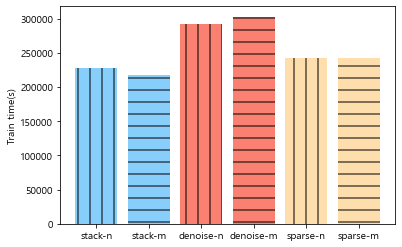

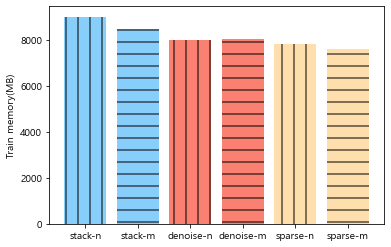

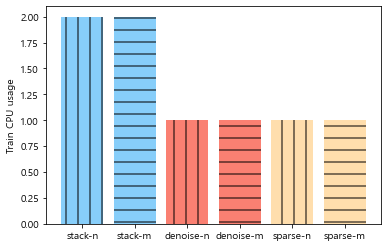

In [ ]:
## PI + Drop_Columns, epochs 25로 뽑아낸 결과임
print(time_list)
print(memory_list)
print(cpu_list)
print("---------")

# time_list = [228000, 218000, 293000, 303000, 242000, 243000]
# memory_list = [8990, 8467, 7982, 8037, 7793, 7574]
# cpu_list = [2.1412, 2.082, 1.660, 1.7, 1.6, 1.8]

# time_list = list(map(int, time_list))
# memory_list = list(map(int, memory_list))
# cpu_list = list(map(int, cpu_list))
print(time_list, "\n", memory_list, "\n", cpu_list, "\n")

x = ["stack-n", "stack-m", "denoise-n", "denoise-m", "sparse-n", "sparse-m"]
bar = plt.bar(x, time_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train time(s)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, memory_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train memory(MB)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, cpu_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train CPU usage")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

In [ ]:
## 얘는 PI로 피처 추출해서 epoch 25로 뽑아낸 결과임
# 지우지 마라.
print(time_list)
print(memory_list)
print(cpu_list)

print(time_list, "\n", memory_list, "\n", cpu_list, "\n")

## 테스트 부분
## 나중에 지우는 셀

x = ["stack-n", "stack-m", "denoise-n", "denoise-m", "sparse-n", "sparse-m"]
bar = plt.bar(x, time_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train time(s)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, memory_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train memory(MB)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, cpu_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train CPU usage")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

[226, 222, 275, 275, 216, 222]
[9694, 9458, 9270, 9383, 9448, 9562]
[2.56172, 1.8847, 1.67671, 1.68515, 1.75108, 1.75244]


[242, 228, 479, 420, 314, 303] 
 [9160, 9286, 9106, 9967, 10360, 10712] 
 [1, 1, 1, 1, 2, 2] 



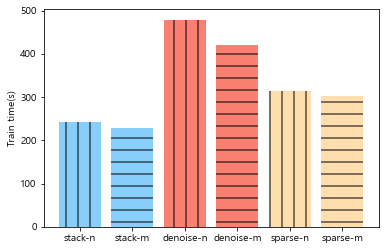

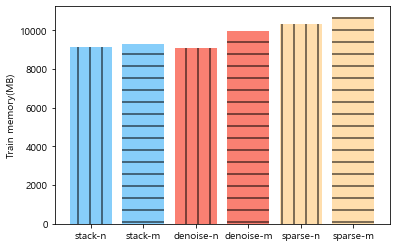

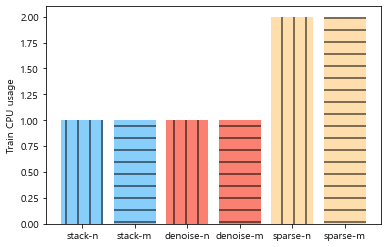

In [ ]:
## 얘는 전체피처 사용해서 epoch 25로 뽑아낸 결과임
## 학습 끝나면 이거 셀 실행 눌러서 출력해봐
print(time_list)
print(memory_list)
print(cpu_list)
print("---------")
time_list = list(map(int, time_list))
memory_list = list(map(int, memory_list))
cpu_list = list(map(int, cpu_list))

print(time_list, "\n", memory_list, "\n", cpu_list, "\n")

## 테스트 부분
## 나중에 지우는 셀

x = ["stack-n", "stack-m", "denoise-n", "denoise-m", "sparse-n", "sparse-m"]
bar = plt.bar(x, time_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train time(s)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, memory_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train memory(MB)")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, cpu_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train CPU usage")
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

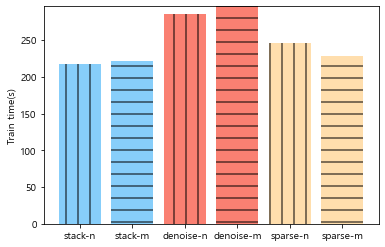

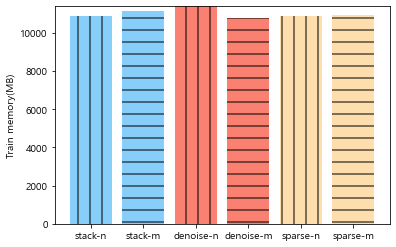

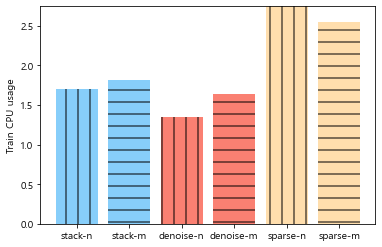

In [ ]:
## 테스트 부분
# all feature vs PI+DropColumn

# [242, 228, 479, 420, 314, 303]
# [9160, 9286, 9106, 9967, 10360, 10712]
# [1.70657, 1.81581, 1.34633, 1.64354, 2.74307, 2.55115]

allfeature_time_list = [218, 221, 286, 296, 246, 228]
allfeature_memory_list =  [10854, 11158, 11382, 10797, 10880, 10920]
allfeature_cpu_list = [1.70657, 1.81581, 1.34633, 1.64354, 2.74307, 2.55115]

extract_time_list = [204, 211, 265, 278, 242, 205]
extract_memory_list = [8990, 8467, 7982, 8037, 7793, 7574]
extract_cpu_list = [2.1412, 2.082, 1.660, 1.724, 1.634, 1.835]

normal_memory_compare = []
max_time = max(max(allfeature_time_list), max(extract_time_list))
max_memory = max(max(allfeature_memory_list), max(extract_memory_list))
max_cpu = max(max(allfeature_cpu_list), max(extract_cpu_list))


x = ["stack-n", "stack-m", "denoise-n", "denoise-m", "sparse-n", "sparse-m"]
bar = plt.bar(x, allfeature_time_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train time(s)")
plt.ylim(0, max_time)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, allfeature_memory_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train memory(MB)")
plt.ylim(0, max_memory)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, allfeature_cpu_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train CPU usage")
plt.ylim(0, max_cpu)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

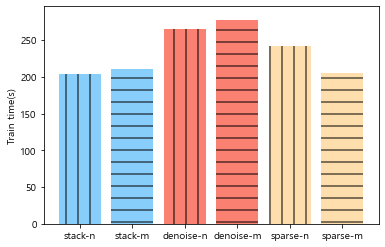

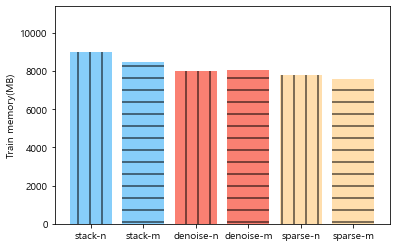

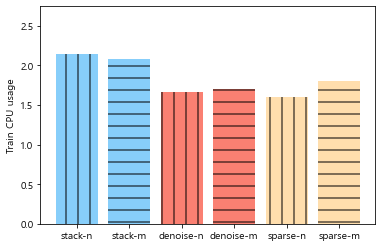

In [ ]:
## 테스트 부분
## 나중에 지우는 셀

x = ["stack-n", "stack-m", "denoise-n", "denoise-m", "sparse-n", "sparse-m"]
bar = plt.bar(x, extract_time_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train time(s)")
plt.ylim(0, max_time)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, extract_memory_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train memory(MB)")
plt.ylim(0, max_memory)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

plt.clf()
bar = plt.bar(x, extract_cpu_list, color=['lightskyblue', 'lightskyblue', 'salmon', 'salmon', 'navajowhite', 'navajowhite'])
plt.ylabel("Train CPU usage")
plt.ylim(0, max_cpu)
bar[0].set_hatch('|')
bar[1].set_hatch('-')
bar[2].set_hatch('|')
bar[3].set_hatch('-')
bar[4].set_hatch('|')
bar[5].set_hatch('-')
plt.show()

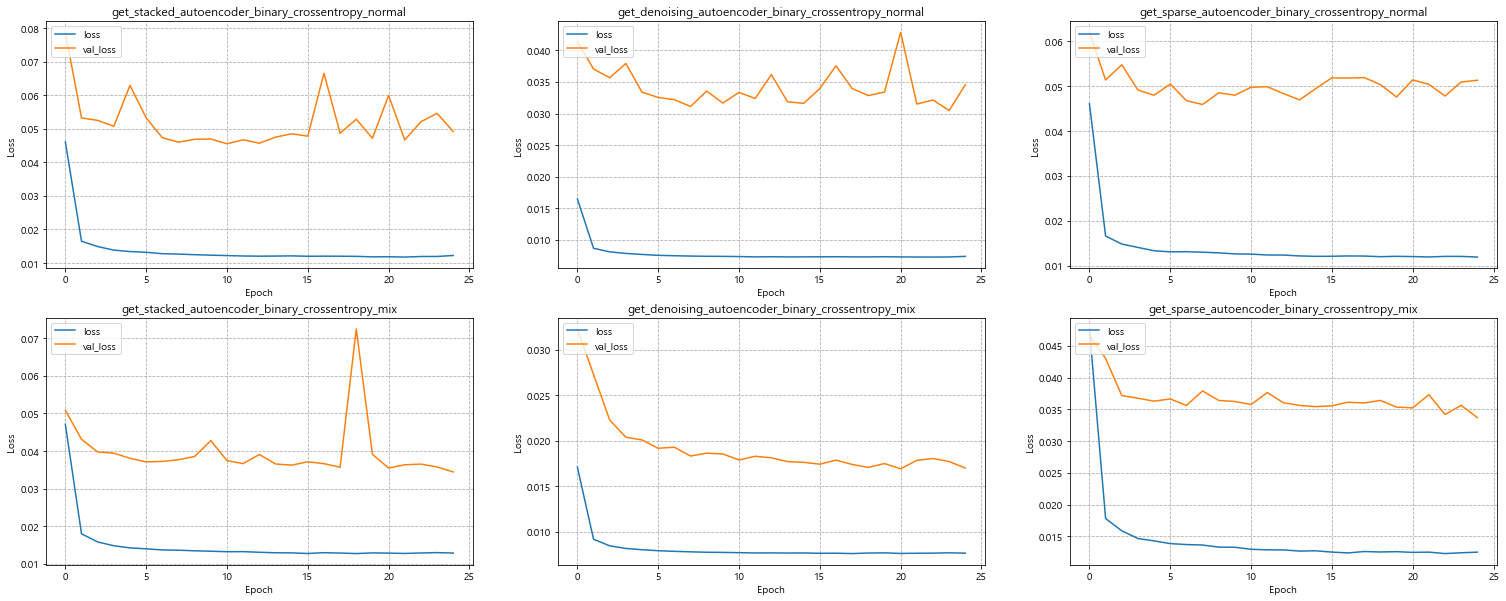

In [ ]:
# Loss graphs
fig, ax = plt.subplots(2, 3, figsize=(26, 10))
for i, h in enumerate(history_list):
    axx = ax[i%2][i//2]
    axx.grid(linestyle='--')
    axx.plot(h.history['loss'])
    axx.plot(h.history['val_loss'])
    axx.set_title(model_list[i][:-3])
    axx.legend(['loss', 'val_loss'], loc='upper left')
    axx.set_xlabel('Epoch')
    axx.set_ylabel('Loss')